### 논문
https://academic.oup.com/bioinformatics/article/37/10/1444/5988714

### 데이터 셋 및 코드 출처
https://www.kaggle.com/code/msandrk/autoencoders-for-microbiome-prediction/notebook

In [1]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from numpy import ndarray
from sklearn.model_selection import KFold
from pandas import DataFrame
from typing import Callable, List, Optional, Tuple, Union

_REGULARIZERS = { 'l1': keras.regularizers.L1, 'l2': keras.regularizers.L2 }
def build_otu_ae_model(input_units: int=717,
                    hidden_layers: Optional[Tuple[Tuple, str]]=((512, 256, 128), 'relu'),
                    hidden_reg_method: Optional[str]=None,
                    hidden_reg_rate: Optional[float]=0.0,
                    use_dropout: bool=False,
                    dropout_rate: float=0.2,
                    latent_layer: Tuple[int, str]=(64, 'relu'),
                    latent_reg_method: Optional[str]='l1',
                    latent_reg_rate: Optional[float]=0.01,
                    decoder_out_activation: Optional[str]=None) -> Tuple[keras.Model, keras.Model]:

    # ENCODER
    encoder_input = keras.Input(input_units, name='encoder_input')
    layer = encoder_input

    if hidden_layers is not None:
        hidden_layers_sizes = hidden_layers[0]
        hidden_activation = hidden_layers[1]

        reg_hidden = None
        if hidden_reg_method:
            reg_hidden = _REGULARIZERS.get(hidden_reg_method, keras.regularizers.L1)
            reg_hidden = reg_hidden(hidden_reg_rate)

        for size in hidden_layers_sizes:
            layer = keras.layers.Dense(size, activation=hidden_activation, activity_regularizer=reg_hidden, name=f"encoder_hidden_{size}")(layer)
            if use_dropout:
                layer = keras.layers.Dropout(dropout_rate)(layer)
    
    latent_size = latent_layer[0]
    latent_activation = latent_layer[1]
    reg_latent = None
    if latent_reg_method:
        reg_latent = _REGULARIZERS.get(latent_reg_method.lower(), keras.regularizers.L1)
        reg_latent = reg_latent(latent_reg_rate)
    
    encoder_output = keras.layers.Dense(latent_size, activation=latent_activation, activity_regularizer=reg_latent, name=f'latent_{latent_size}')(layer)

    encoder_model = keras.Model(inputs=encoder_input, outputs=encoder_output, name='otu_encoder')

    # DECODER
    decoder_input = keras.Input(latent_size, name='decoder_input')
    layer = decoder_input
    if hidden_layers is not None:
        for i, size in enumerate(reversed(hidden_layers_sizes)):
            layer = keras.layers.Dense(size, activation=hidden_activation, activity_regularizer=reg_hidden,
                                       name=f'decoder_hidden_{size}')(layer)
            if use_dropout:
                layer = keras.layers.Dropout(dropout_rate)(layer)

    decoder_output = keras.layers.Dense(input_units, activation=decoder_out_activation, name='decoded_output')(layer)

    decoder_model = keras.Model(decoder_input, decoder_output, name='decoder')
    
    # AUTOENCODER
    autoencoder_input = keras.Input(input_units, name='otu_counts')
    encoded_counts = encoder_model(autoencoder_input)
    decoded_counts = decoder_model(encoded_counts)
    autoencoder = keras.Model(autoencoder_input, decoded_counts, name='autoencoder')

    # autoencoder.summary()

    return autoencoder, encoder_model, decoder_model

def build_env_model(input_units: int=36,
                    hidden_layers: Optional[Tuple[Tuple, str]]=((64, 128), 'relu'),
                    output_layer: Tuple[int, str]=(64, 'relu'),
                    use_batch_norm: bool=False) -> keras.Model:
    
    input_layer = keras.Input(input_units, name='input_layer')
    layer = input_layer

    if use_batch_norm:
        layer = keras.layers.BatchNormalization()(input_layer)

    if hidden_layers:
        hidden_sizes = hidden_layers[0]
        hidden_activation = hidden_layers[1]

        for size in hidden_sizes:
            layer = keras.layers.Dense(size, activation=hidden_activation, name=f'env_net_hidden_{size}')(layer)
    
    output_layer = keras.layers.Dense(output_layer[0], activation=output_layer[1], name='env_output_')(layer)

    model = keras.Model(input_layer, output_layer, name='env_to_latent')

    return model


def kfold_training(model_gen: Callable[[], keras.Model],
                    X_data: Union[DataFrame, ndarray],
                    Y_data: Union[DataFrame, ndarray, None],
                    n_folds: int=5,
                    shuffle_data: bool=True,
                    random_state: int=21,
                    epochs: int=200,
                    batch_size: int=128,
                    optimizer: keras.optimizers.Optimizer=keras.optimizers.Adam(),
                    loss='mse',
                    metrics='mse',
                    callbacks: Optional[List[keras.callbacks.Callback]]=[],
                    plt_losses: bool=True,
                    print_model_summary: bool=True,
                    verbose: int=0
                    ):
    
    kf = KFold(n_splits=n_folds, shuffle=shuffle_data, random_state=random_state)
    
    models = []

    Y_data = X_data if Y_data is None else Y_data

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_data)):
        
        curr_fold = dict()
        

        # BUILD MODEL AND COMPILE IT
        keras.backend.clear_session()
        curr_model = model_gen()

        if fold == 0 and print_model_summary:
            curr_model.summary()
        
        curr_model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics
        )
        
        # SEPERATE TRAINING AND VALIDATION DATA
        if isinstance(X_data, DataFrame):
            X_train = X_data.iloc[train_idx]
            X_val = X_data.iloc[val_idx]
        else:
            X_train = X_data[train_idx]
            X_val = X_data[val_idx]
        
        if isinstance(Y_data, DataFrame):
            Y_train = Y_data.iloc[train_idx]
            Y_val = Y_data.iloc[val_idx]
        else:
            Y_train = Y_data[train_idx]
            Y_val = Y_data[val_idx]
        
        print('#'*25); print('#### FOLD',fold+1)
        history = curr_model.fit(
            X_train,
            Y_train,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            validation_data=(X_val, Y_val),
            verbose=verbose
        )

        if verbose == 0:
            print(f"Number of epochs ran: {len(history.history['loss'])}")
            print(f"Minimal validation loss for fold #{fold+1}: {min(history.history['val_loss'])}")

        curr_fold['model'] = history.model
        curr_fold['history'] = history.history

        models.append(curr_fold)
        
        # LOSS
        if plt_losses:
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'])
            plt.show()
    
    return models

In [2]:
import warnings
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy.stats import pearsonr as __pearsonr
from sklearn.model_selection import train_test_split
from typing import Tuple, Optional, Callable, Union


def total_sum_scaler(data: pd.DataFrame) -> pd.DataFrame:
    corr_data = data + 1e-6    # add a small number to prevent division by 0
    row_sums = corr_data.sum(axis=1)
    return corr_data.div(row_sums, axis=0)

def center_log_ratio(data: pd.DataFrame) -> pd.DataFrame:
    corr_data = data + 1e-6 # add a small number to evade calculating log(0) which is invalid
    log_data = np.log(corr_data)    
    g_mean = log_data.mean(axis=1)
    
    return log_data.sub(g_mean, axis=0)

def load_train_test_data(otu_filename: str,
                         metadata_filename: str,
                         otu_sep: str='\t',
                         metadata_sep: str='\t',
                         metadata_features_subset: Optional[list]=None,
                         test_size: float=0.2,
                         random_state: int=21) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    metadata_df = pd.read_csv(metadata_filename, sep=metadata_sep, index_col=0)
    metadata_df = metadata_df[metadata_features_subset] if metadata_features_subset is not None else metadata_df
    
    otu_df = pd.read_csv(otu_filename, sep=otu_sep, index_col=0, dtype=np.int32)    
    otu_df = otu_df.T if otu_df.shape[1] == metadata_df.shape[0] else otu_df
    
    otu_X_train, otu_X_test = train_test_split(otu_df, test_size=test_size, random_state=random_state)
    env_X_train = metadata_df.loc[otu_X_train.index]
    env_X_test = metadata_df.loc[otu_X_test.index]

    return otu_X_train, otu_X_test, env_X_train, env_X_test

def one_hot_encode(df: pd.DataFrame, categorical_cols: list, prefixes:dict=None) -> pd.DataFrame:
    prefixes = categorical_cols if prefixes is None else prefixes
    return pd.get_dummies(df, columns=categorical_cols, prefix=prefixes)

def preprocess_train_test(otu_train: pd.DataFrame,
                        otu_test: pd.DataFrame,
                        env_train: pd.DataFrame,
                        env_test: pd.DataFrame,
                        otu_transform: Callable[[pd.DataFrame], pd.DataFrame]=center_log_ratio
                        ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    otu_train = otu_transform(otu_train)
    otu_test = otu_transform(otu_test)

    
    env_num_features = env_train.select_dtypes('number').columns
    env_cat_features = env_train.columns.difference(env_num_features)

    # normalize numerical features
    env_train[env_num_features] = (env_train[env_num_features] - env_train[env_num_features].min()) \
                                / (env_train[env_num_features].max() - env_train[env_num_features].min())

    env_test[env_num_features] = (env_test[env_num_features] - env_test[env_num_features].min()) \
                                / (env_test[env_num_features].max() - env_test[env_num_features].min())

    # one-hot encode categorical features
    full_env_data_encoded = one_hot_encode(pd.concat([env_train, env_test], axis=0), env_cat_features)

    env_train = full_env_data_encoded.loc[env_train.index]
    env_test = full_env_data_encoded.loc[env_test.index]

    return otu_train, otu_test, env_train, env_test

def pearson(y_true: Union[np.ndarray, pd.DataFrame, tf.Tensor],
            y_pred: Union[np.ndarray, pd.DataFrame, tf.Tensor]):
    
    if isinstance(y_true, (np.ndarray, pd.DataFrame)):
        # not used as a metric in keras.Model.fit method
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        with warnings.catch_warnings():
            warnings.simplefilter('ignore') # ignore warning about constant or almost constant sample vectors
            result = [__pearsonr(rv, pv)[0] for rv, pv in zip(y_true, y_pred)]
            result = np.nan_to_num(result)  # replace NaNs with 0
            return np.mean(result)
    else:
        # used as a metric callable during training
        y_true_mean = tf.reduce_mean(y_true, axis=-1, keepdims=True)
        y_pred_mean = tf.reduce_mean(y_pred, axis=-1, keepdims=True)
        
        y_true_diffs = y_true - y_true_mean
        y_pred_diffs = y_pred - y_pred_mean

        numer = tf.reduce_sum(y_true_diffs * y_pred_diffs, axis=-1)
        denom = tf.sqrt(tf.reduce_sum(y_true_diffs * y_true_diffs, axis=-1))
        denom *= tf.sqrt(tf.reduce_sum(y_pred_diffs * y_pred_diffs, axis=-1))

        result = numer / denom
        result = tf.where(tf.math.is_nan(result), tf.zeros_like(result), result)    # replace NaN with 0

        return result

def bray_curtis(y_true: Union[np.ndarray, pd.DataFrame, tf.Tensor],
                y_pred: Union[np.ndarray, pd.DataFrame, tf.Tensor]):

    if isinstance(y_true, (np.ndarray, pd.DataFrame)):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        numer = np.abs(y_true - y_pred)
        denom = np.abs(y_true + y_pred)

        result = np.sum(numer, axis=-1) / np.sum(denom, axis=-1)
        return np.mean(result)
    else:
        numer = tf.reduce_sum(tf.abs(y_true - y_pred), axis=-1)
        denom = tf.reduce_sum(tf.abs(y_true + y_pred), axis=-1)

        return numer / denom

def root_relative_squared_err(y_true: Union[np.ndarray, pd.DataFrame],
                            y_pred: Union[np.ndarray, pd.DataFrame]):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.to_numpy()

    result=np.zeros(y_true.shape[0])

    for i, (true_otu,pred_otu) in enumerate(zip(y_true,y_pred)):
        mean_otu = true_otu.mean()
        numer=((pred_otu - true_otu)**2).sum()
        denom=((pred_otu - mean_otu)**2).sum()
        result[i]= numer / denom
    
    return np.sqrt(result)

def get_best_predicts(tax_filename: str, rank: str, rrses: pd.DataFrame, sep: str='\t', num_top: Optional[int]=35):
    taxa_table = pd.read_csv(tax_filename, sep=sep, index_col=0)[rank]
    
    rrses_column = rrses.columns.values[0]
    data = pd.concat([taxa_table, rrses], axis=1).sort_values(rrses_column)

    if num_top is not None:
        return data.iloc[:num_top]

    return data

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborfn as sns

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold


print(f'Tensorflow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}\n')

Tensorflow version: 2.9.1
Keras version: 2.9.0



In [5]:
otu_filepath = './otu_table_all_80.csv'
metadata_filepath = './metadata_table_all_80.csv'
tax_filepath = './tax_table_all_80_cleanNames.csv'

In [9]:
ENV_FEATURES = ['Temperature', 'Precipitation3Days', 'age']
OTU_TRANSFORM = center_log_ratio

EPOCHS = 300
BATCH_SIZE = 128

AE_HIDDEN_LAYERS = ((800,), 'tanh')
HIDDEN_REG_MET = 'l1'
HIDDEN_REG_RATE = 0.01
USE_DROPOUT = True

LATENT_SIZE = 900
LATENT_ACTIVATION = 'tanh'
LATENT_LAYER = (LATENT_SIZE, LATENT_ACTIVATION)
LATENT_REG_MET = 'l1'
LATENT_REG_RATE = 0.01

AE_LOSS = 'mse'
AE_METRICS = [pearson, bray_curtis]
AE_CALLBACKS = [keras.callbacks.EarlyStopping(patience=10, verbose=1),
               keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)]


ENV_HIDDEN_LAYERS = ((36, 144, 576), 'tanh')
ENV_OUTPUT = (LATENT_SIZE, 'tanh')
USE_BATCH_NORM = True
ENV_LOSS = 'mse'
ENV_METRICS = ['mse']
ENV_CALLBACKS = [keras.callbacks.EarlyStopping(patience=10, verbose=1),
                keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)]

In [11]:
otu_train, otu_test, env_train, env_test = load_train_test_data(otu_filename=otu_filepath,
                                        metadata_filename=metadata_filepath,
                                        metadata_features_subset=ENV_FEATURES)

In [12]:
otu_train.shape

(3779, 717)

In [65]:
env_train.head()

,Temperature,Precipitation3Days,age
11116.I25A078.1195840,0.568627,0.256798,0.263158
11116.I17A088.1194851,0.656863,0.036254,0.473684
11116.I21A087.1197693,0.712418,0.009063,0.421053
11116.L29A068.1194264,0.166667,0.274924,0.105263
11116.A25A061.1196152,0.705882,0.003021,0.000000


In [66]:
env_test.head()

,Temperature,Precipitation3Days,age
11116.I18A099.1195841,0.617647,0.021148,0.631579
11116.I30A066.1197415,0.647059,0.141994,0.052632
11116.L23A086.1198304,0.712418,0.009063,0.421053
11116.I04A118.1196372,0.000000,0.190332,1.000000
11116.I26A092.1194813,0.875817,0.063444,0.526316


In [67]:
otu_train.head()

otuids,4479944,513055,519510,810959,849092,1042671,818174,585221,1033380,875704,...,966091,55354,515709,902698,591499,569066,823091,219094,961783,823633
11116.I25A078.1195840,-10.606671,-10.606671,6.674576,-10.606671,8.084037,3.208841,-10.606671,-10.606671,-10.606671,5.154750,...,-10.606671,-10.606671,5.406064,6.466936,4.595134,5.000599,-10.606671,-10.606671,6.735200,-10.606671
11116.I17A088.1194851,5.547271,-11.446294,2.369218,3.467829,8.718356,-11.446294,-11.446294,-11.446294,-11.446294,3.978655,...,3.062364,4.767112,4.854123,6.153406,4.448658,-11.446294,2.369218,-11.446294,6.943928,3.978655
11116.I21A087.1197693,4.901041,-10.860380,5.257716,-10.860380,7.664661,-10.860380,-10.860380,-10.860380,-10.860380,-10.860380,...,-10.860380,-10.860380,5.999653,6.420867,4.341426,-10.860380,-10.860380,-10.860380,9.923981,-10.860380
11116.L29A068.1194264,3.997388,-11.609882,6.117651,2.205629,6.950561,2.205629,4.285070,-11.609882,-11.609882,2.898776,...,4.151539,5.606826,5.341123,6.468308,4.285070,4.603524,5.639616,-11.609882,6.810799,-11.609882
11116.A25A061.1196152,6.748807,-11.193838,7.504474,-11.193838,4.007967,-11.193838,7.715423,-11.193838,-11.193838,5.757167,...,6.450314,2.621673,5.454886,6.428335,4.413432,4.924258,5.186622,-11.193838,5.019568,5.260730


In [71]:
otu_test

otuids,4479944,513055,519510,810959,849092,1042671,818174,585221,1033380,875704,...,966091,55354,515709,902698,591499,569066,823091,219094,961783,823633
11116.I18A099.1195841,4.314480,4.026798,4.719945,-10.887325,7.334905,-10.887325,-10.887325,-10.887325,-10.887325,4.537624,...,4.537624,2.928187,6.224023,7.190866,3.621334,5.007627,2.928187,-10.887325,8.819830,5.007627
11116.I30A066.1197415,5.074464,-11.449097,7.592161,-11.449097,6.748441,4.312324,-11.449097,-11.449097,-11.449097,-11.449097,...,2.366415,2.366415,4.312324,5.698618,-11.449097,2.366415,3.465027,-11.449097,5.624510,3.059562
11116.L23A086.1198304,4.206528,-9.608984,6.979115,-9.608984,10.608444,-9.608984,6.285968,-9.608984,-9.608984,-9.608984,...,4.899674,-9.608984,4.206528,7.384580,4.899674,7.607724,4.206528,-9.608984,11.474052,-9.608984
11116.I04A118.1196372,-8.915874,-8.915874,-8.915874,-8.915874,10.603419,-8.915874,-8.915874,-8.915874,-8.915874,6.979078,...,4.899637,-8.915874,-8.915874,6.691396,6.691396,7.297531,-8.915874,-8.915874,13.652850,-8.915874
11116.I26A092.1194813,-7.890408,-7.890408,6.618250,5.925103,9.796303,-7.890408,-7.890408,-7.890408,-7.890408,-7.890408,...,-7.890408,-7.890408,-7.890408,8.758316,5.925103,-7.890408,-7.890408,-7.890408,9.421610,-7.890408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11116.A01B091.1196732,11.483534,-3.025124,-3.025124,-3.025124,-3.025124,-3.025124,11.483534,-3.025124,-3.025124,-3.025124,...,-3.025124,-3.025124,-3.025124,-3.025124,-3.025124,-3.025124,-3.025124,-3.025124,18.487508,-3.025124
11116.A17A094.1196344,-0.386477,-0.386477,-0.386477,-0.386477,-0.386477,-0.386477,-0.386477,-0.386477,-0.386477,-0.386477,...,-0.386477,-0.386477,-0.386477,-0.386477,-0.386477,-0.386477,-0.386477,-0.386477,16.319405,-0.386477
11116.A13D064.1196775,7.403379,-9.407864,7.585700,5.793941,-9.407864,6.199406,8.627154,-9.407864,-9.407864,6.017084,...,6.353557,-9.407864,5.506259,5.100794,5.100794,6.487088,4.407647,-9.407864,8.751452,5.100794
11116.L11A086.1195419,4.620502,-10.804446,7.764655,-10.804446,5.576014,-10.804446,7.054116,-10.804446,-10.804446,3.704212,...,4.956975,5.901436,4.620502,6.189118,4.620502,4.956975,4.802824,-10.804446,9.779558,-10.804446


In [25]:
len(otu_train.index.unique())

3779

In [18]:
print(f"Number of training examples: {otu_train.shape[0]}")
print(f"Number of test examples: {otu_test.shape[0]}")

Number of training examples: 3779
Number of test examples: 945


In [26]:
# Normalize OTU and enviromental data, one-hot encode categorical features in enviromental data
otu_train, otu_test, env_train, env_test = preprocess_train_test(otu_train, otu_test,
                                                                       env_train, env_test,
                                                                       otu_transform=OTU_TRANSFORM
                                                                    )

print(f"Number of features before one-hot encoding: {len(ENV_FEATURES)}")
ENV_FEATURES = env_train.columns
ENV_FEATURES_CNT = len(ENV_FEATURES)
print(f"Number of features after one-hot encoding: {ENV_FEATURES_CNT}")

Number of features before one-hot encoding: 3
Number of features after one-hot encoding: 3


In [27]:
# def reg_model_generator(hidden_reg_method='l1', hidden_reg_rate=0.01, latent_reg_method='l1', latent_reg_rate=0.01):
def model_generator():
    autoencoder, _, _ = build_otu_ae_model(hidden_layers=AE_HIDDEN_LAYERS,
                                                hidden_reg_method=HIDDEN_REG_MET,
                                                hidden_reg_rate=HIDDEN_REG_RATE,
                                                use_dropout=USE_DROPOUT,
                                                latent_layer=LATENT_LAYER,
                                                latent_reg_method=LATENT_REG_MET,
                                                latent_reg_rate=LATENT_REG_RATE
                                                )
    return autoencoder
#     return model_generator

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 otu_counts (InputLayer)     [(None, 717)]             0         
                                                                 
 otu_encoder (Functional)    (None, 900)               1295300   
                                                                 
 decoder (Functional)        (None, 717)               1295117   
                                                                 
Total params: 2,590,417
Trainable params: 2,590,417
Non-trainable params: 0
_________________________________________________________________
#########################
#### FOLD 1
Epoch 84: early stopping
Number of epochs ran: 84
Minimal validation loss for fold #1: 30.302507400512695


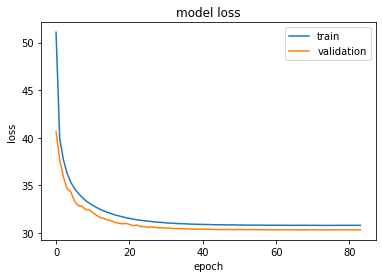

#########################
#### FOLD 2
Epoch 125: early stopping
Number of epochs ran: 125
Minimal validation loss for fold #2: 37.23002624511719


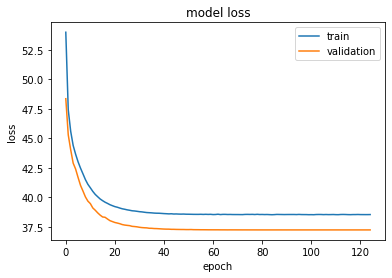

#########################
#### FOLD 3
Epoch 113: early stopping
Number of epochs ran: 113
Minimal validation loss for fold #3: 37.261878967285156


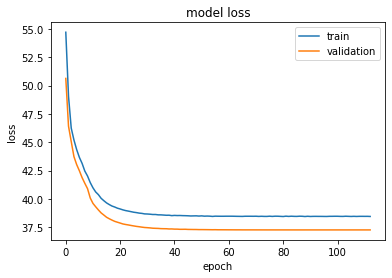

#########################
#### FOLD 4
Epoch 133: early stopping
Number of epochs ran: 133
Minimal validation loss for fold #4: 38.25014877319336


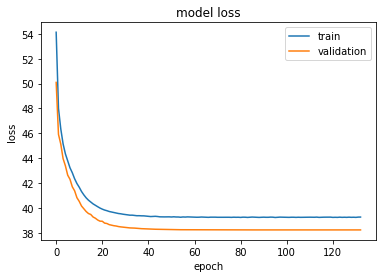

#########################
#### FOLD 5
Epoch 134: early stopping
Number of epochs ran: 134
Minimal validation loss for fold #5: 37.6640739440918


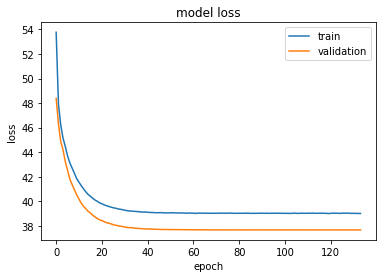

In [28]:
# ae_model_generator = reg_model_generator(HIDDEN_REG_MET, HIDDEN_REG_RATE, LATENT_REG_MET, LATENT_REG_RATE)
ae_training = kfold_training(model_generator,
                                    X_data=otu_train,
                                    Y_data=None,
                                    epochs=EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    loss=AE_LOSS,
                                    metrics=AE_METRICS,
                                    callbacks=AE_CALLBACKS
                                   )

In [29]:
ae_val_pearsons = [np.array(m['history']['val_pearson']).mean() for m in ae_training]
print(f"Mean validation pearson correlation coefficient of OTU autoencoder for each fold: {ae_val_pearsons}")
print(f"Mean validation pearson correlation coefficient of OTU autoencoder over all folds: {np.array(ae_val_pearsons).mean()}")

Mean validation pearson correlation coefficient of OTU autoencoder for each fold: [0.8164032917647135, 0.7979634218215942, 0.8025848454078742, 0.8050202099900496, 0.8057539765514544]
Mean validation pearson correlation coefficient of OTU autoencoder over all folds: 0.8055451491071371


In [30]:
# sort autoencoders by pearson
ae_training = sorted(ae_training, reverse=True, key=lambda fold: fold['history']['val_pearson'])

# get second best autoencoder in case best model is outlier
ae_model = ae_training[0]['model']

# Autoencoder structure is Input layer -> Encoder -> Decoder
encoder = ae_model.layers[1]
decoder = ae_model.layers[2]

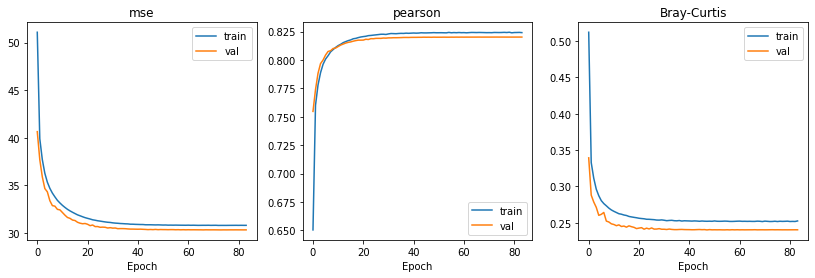

In [33]:
orig_fig_size = plt.rcParams['figure.figsize']

plt.rcParams['figure.figsize'] = [14, 4]

train_history = ae_training[0]['history']
plt.subplot(1, 3, 1)
plt.title('mse')
plt.plot(train_history['loss'])
plt.plot(train_history['val_loss'])
plt.legend(['train', 'val'])
plt.xlabel('Epoch')
# plt.ylabel('Srednje kvadratno odstupanje')

plt.subplot(1, 3, 2)
plt.title('pearson')
plt.plot(train_history['pearson'])
plt.plot(train_history['val_pearson'])
plt.legend(['train', 'val'])
plt.xlabel('Epoch')
# plt.ylabel('Pearsonova korelacija')

plt.subplot(1, 3, 3)
plt.title('Bray-Curtis')
plt.plot(train_history['bray_curtis'])
plt.plot(train_history['val_bray_curtis'])
plt.legend(['train', 'val'])
plt.xlabel('Epoch')

# plt.savefig('ae_800_900.png', dpi=300, bbox_inches='tight', pad_inches=0.05, facecolor='white', transparent=False)
plt.show()

plt.rcParams['figure.figsize'] = orig_fig_size

In [35]:
ae_test_pearson = pearson(otu_test, ae_model.predict(otu_test))
print(f"Mean pearson correlation coefficient of OTU autoencoder on TEST dataset: {ae_test_pearson}")

30/30 [==============================] - 0s 1ms/step
Mean pearson correlation coefficient of OTU autoencoder on TEST dataset: 0.8165885518622485


In [36]:
ae_test_bc = bray_curtis(otu_test, ae_model.predict(otu_test))
print(f"Mean Bray-Curtis dissimilarity of OTU autoencoder on TEST dataset: {ae_test_bc}")

30/30 [==============================] - 0s 1ms/step
Mean Bray-Curtis dissimilarity of OTU autoencoder on TEST dataset: 0.24485229804168024


In [37]:
def env_model_generator():
    returnc(input_units=ENV_FEATURES_CNT,
                                   hidden_layers=ENV_HIDDEN_LAYERS,
                                   output_layer=ENV_OUTPUT,
                                   use_batch_norm=USE_BATCH_NORM)

119/119 [==============================] - 0s 530us/step
Model: "env_to_latent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3)]               0         
                                                                 
 batch_normalization (BatchN  (None, 3)                12        
 ormalization)                                                   
                                                                 
 env_net_hidden_36 (Dense)   (None, 36)                144       
                                                                 
 env_net_hidden_144 (Dense)  (None, 144)               5328      
                                                                 
 env_net_hidden_576 (Dense)  (None, 576)               83520     
                                                                 
 env_output_ (Dense)         (None, 900)               519300 

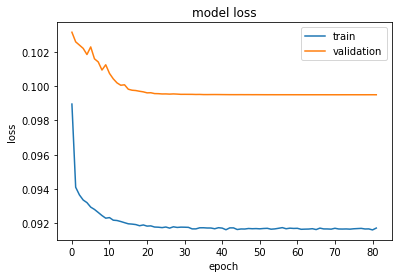

#########################
#### FOLD 2
Epoch 75: early stopping
Number of epochs ran: 75
Minimal validation loss for fold #2: 0.09259983897209167


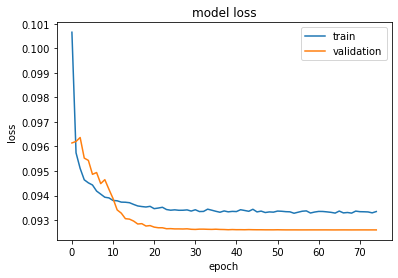

#########################
#### FOLD 3
Epoch 81: early stopping
Number of epochs ran: 81
Minimal validation loss for fold #3: 0.09263195097446442


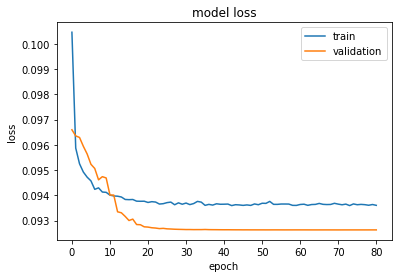

#########################
#### FOLD 4
Epoch 66: early stopping
Number of epochs ran: 66
Minimal validation loss for fold #4: 0.09220404922962189


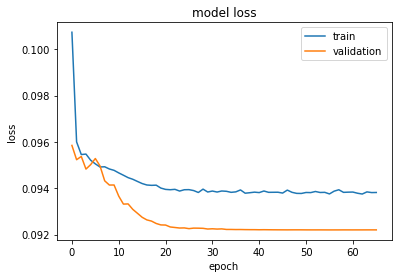

#########################
#### FOLD 5
Epoch 71: early stopping
Number of epochs ran: 71
Minimal validation loss for fold #5: 0.09067755937576294


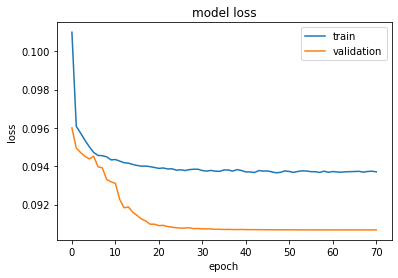

In [38]:
encoded_otus = encoder.predict(otu_train)
env_model_training = kfold_training(env_model_generator,
                                            X_data=env_train,
                                            Y_data=encoded_otus,
                                            epochs=EPOCHS,
                                            batch_size=BATCH_SIZE,
                                            loss=ENV_LOSS,
                                            metrics=ENV_METRICS,
                                            callbacks=ENV_CALLBACKS
                                            )

In [39]:
env_model_training = sorted(env_model_training, key=lambda fold: min(fold['history']['val_loss']))

# get second best environment model
env_model = env_model_training[0]['model']

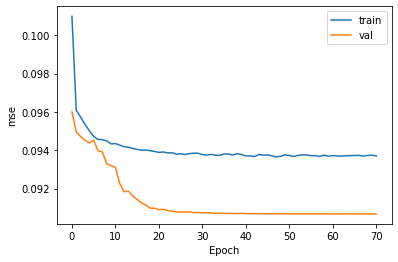

In [42]:
orig_fig_size = plt.rcParams['figure.figsize']

# plt.rcParams['figure.figsize'] = [8, ]
env_train_history = env_model_training[0]['history']
plt.plot(env_train_history['loss'])
plt.plot(env_train_history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.legend(['train', 'val'])
plt.savefig('env_TPA_800_900.png', dpi=300, bbox_inches='tight', pad_inches=0.05, facecolor='white', transparent=False)
plt.show()

plt.rcParams['figure.figsize'] = orig_fig_size

In [43]:
# FINAL MODEL
input_layer = keras.Input(ENV_FEATURES_CNT, name="full_model_input")
encoded_input = env_model(input_layer)
decoded_output = decoder(encoded_input)
final_model = keras.Model(input_layer, decoded_output, name='full_model')

In [70]:
final_model.summary()

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 full_model_input (InputLaye  [(None, 3)]              0         
 r)                                                              
                                                                 
 env_to_latent (Functional)  (None, 900)               608304    
                                                                 
 decoder (Functional)        (None, 717)               1295117   
                                                                 
Total params: 1,903,421
Trainable params: 1,903,415
Non-trainable params: 6
_________________________________________________________________


In [45]:
print(f"Final predictor mean pearson coeff on TRAINING data: {pearson(otu_train, final_model.predict(env_train))}")

119/119 [==============================] - 0s 926us/step
Final predictor mean pearson coeff on TRAINING data: 0.7352503845434335


In [46]:
final_predicts = final_model.predict(env_test)

30/30 [==============================] - 0s 1ms/step


In [48]:
print(f"Final predictor mean pearson coeff on TEST data: {pearson(otu_test, final_predicts)}")

Final predictor mean pearson coeff on TEST data: 0.7300176062426795


In [49]:
print(f"Final predictor mean Bray-Curtis dissimilarity on TEST data: {bray_curtis(otu_test, final_predicts)}")

Final predictor mean Bray-Curtis dissimilarity on TEST data: 0.3289516476423447


In [63]:
final_predicts.shape

(945, 717)

In [79]:
rrse = root_relative_squared_err(otu_test.T, final_predicts.T)
rrse = pd.DataFrame(rrse, index=otu_test.columns, columns=['RRSE'])
result = get_best_predicts(tax_filepath, 'Rank2', rrse, num_top=71)
result.shape

(71, 2)

In [80]:
rrse

,RRSE
otuids,
4479944,5.216528
513055,3.290768
519510,4.505370
810959,4.667864
849092,2.329309
...,...
569066,4.274550
823091,4.424680
219094,3.373616


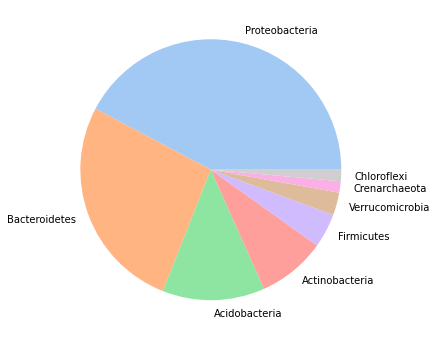

In [81]:
orig_fig_size = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [12, 6]
plt.pie(result['Rank2'].value_counts(),
       labels=result['Rank2'].unique(),
       colors=sns.color_palette('pastel')[0:10],
       )
#plt.savefig('best_10p_OTUs_800_900.png', dpi=300, bbox_inches='tight', pad_inches=0.05, facecolor='white')
plt.show()
plt.rcParams['figure.figsize'] = orig_fig_size

In [75]:
result

,Rank2,RRSE
141365,Proteobacteria,1.247804
646549,Proteobacteria,1.268921
58633,Bacteroidetes,1.373011
353494,Bacteroidetes,1.399870
683649,Acidobacteria,1.400569
...,...,...
1640195,Proteobacteria,10.299170
1009440,Proteobacteria,10.323813
360823,Acidobacteria,12.776555
256569,Chlorobi,13.491008
